In [1]:
# Imports
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Pytorch Gpu Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

import matplotlib.pyplot as plt

# Matplotlib svg plots for better pictures
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

import seaborn as sns
import pandas as pd
from torchsummary import summary

# Sklearn
from sklearn.model_selection import train_test_split

In [2]:
# Import dataset
iris = pd.read_csv(
    "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv"
)

# Convert dataset from pandas datafram to tensor
data = torch.tensor(iris[iris.columns[0:4]].values).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species == "setosa"] = (
    0  # We don't need this line as torch.zeros initialize the tensor with zeros
)
labels[iris.species == "versicolor"] = 1
labels[iris.species == "virginica"] = 2

# Train Test split manual


In [ ]:
# Seperate data into train and test sets

# Training Examples
propTrain = 0.8  # in proportion not percent
nTraining = int(len(labels) * propTrain)

# initialize a boolean vector to select data and labels
trainTestBool = np.zeros(len(labels), dtype=bool)

# trainTestBool[range(nTraining)] = True # Not the right way to do the split because it will not randomise data

# This is the better way
items2use4train = np.random.choice(range(len(labels)), nTraining, replace=False)
trainTestBool[items2use4train] = True


print(trainTestBool)

In [ ]:
# Let's check wether train and test are balanced or not?
print(f"Average of full data: {torch.mean(labels.float())}")
print(" ")
print(f"Average of training data: {torch.mean(labels[trainTestBool].float())}")
print(" ")
print(f"Average of test data: {torch.mean(labels[~trainTestBool].float())}")
print(" ")

In [ ]:
# Model
NNModelIris = nn.Sequential(
    nn.Linear(4, 128), nn.ReLU(), nn.Linear(128, 64), nn.ReLU(), nn.Linear(64, 3)
)
# Loss Function
lossFun = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(NNModelIris.parameters(), lr=0.01)

In [ ]:
# Complete Dataset Shape
print(f"Complete data shape: {data.shape}")
# Training Dataset Shape
print(f"Training data shape: {data[trainTestBool, :].shape}")
# Testing Dataset Shape
print(f"Testing data shape: {data[~trainTestBool, :].shape}")

In [ ]:
# Train the model

nEpochs = 1000

# initialize losses
losses = torch.zeros(nEpochs)
ongoingAcc = []

# Loop over epochs
for epoch in range(nEpochs):

    # Forward pass
    yHat = NNModelIris(data[trainTestBool, :])

    # Compute accuracy
    ongoingAcc.append(
        100
        * torch.mean(
            (torch.argmax(yHat, axis=1) == labels[trainTestBool]).cpu().float()
        )
    )

    # Compute Loss
    loss = lossFun(yHat, labels[trainTestBool])
    losses[epoch] = loss

    # Backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
# Test the model

# Compute train accuracy
predictions_train = NNModelIris(data[trainTestBool, :])
trainAccuracy = 100 * torch.mean(
    (torch.argmax(predictions_train, axis=1) == labels[trainTestBool]).cpu().float()
)

# Compute Test accuracy
predictions_test = NNModelIris(data[~trainTestBool, :])
testAccuracy = 100 * torch.mean(
    (torch.argmax(predictions_test, axis=1) == labels[~trainTestBool]).cpu().float()
)

print(f"Final Train accuracy: {trainAccuracy}")
print(f"Final test accuracy: {testAccuracy}")

# Train Test Split Using sklearn train_test_split


In [3]:
fakeData = (
    np.tile(np.array([1, 2, 3, 4]), (10, 1)) + np.tile(10 * np.arange(1, 11), (4, 1)).T
)
fakeLabels = np.arange(10) > 4
fakeData, fakeLabels

(array([[ 11,  12,  13,  14],
        [ 21,  22,  23,  24],
        [ 31,  32,  33,  34],
        [ 41,  42,  43,  44],
        [ 51,  52,  53,  54],
        [ 61,  62,  63,  64],
        [ 71,  72,  73,  74],
        [ 81,  82,  83,  84],
        [ 91,  92,  93,  94],
        [101, 102, 103, 104]]),
 array([False, False, False, False, False,  True,  True,  True,  True,
         True]))

In [4]:
# Use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(
    fakeData, fakeLabels, test_size=0.2, train_size=0.8
)

# print out the sizes
print("Training data size: " + str(train_data.shape))
print("Test data size: " + str(test_data.shape))
print(" ")

# print out the train/test data
print("Training data: ")
print(train_data)
print(" ")

print("Test data: ")
print(test_data)

Training data size: (8, 4)
Test data size: (2, 4)
 
Training data: 
[[91 92 93 94]
 [81 82 83 84]
 [61 62 63 64]
 [31 32 33 34]
 [11 12 13 14]
 [21 22 23 24]
 [41 42 43 44]
 [71 72 73 74]]
 
Test data: 
[[101 102 103 104]
 [ 51  52  53  54]]


In [17]:
# a function that creates the ANN model


def createANewModel():

    # model architecture
    ANNiris = nn.Sequential(
        nn.Linear(4, 64),  # input layer
        nn.ReLU(),  # activation unit
        nn.Linear(64, 64),  # hidden layer
        nn.ReLU(),  # activation unit
        nn.Linear(64, 3),  # output units
    )

    # loss function
    lossFun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr=0.001)

    return ANNiris, lossFun, optimizer

In [25]:
# train the model

# global parameter
numepochs = 200


def trainTheModel(trainProp):

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # loop over epochs
    for epochi in range(numepochs):

        # separate train from test data
        # Note 1: unique split for each epoch!
        # Note 2: here we specify the training size, not the testing size!
        X_train, X_test, y_train, y_test = train_test_split(
            data, labels, train_size=trainProp
        )

        # forward pass and loss
        yHat = ANNiris(X_train)
        loss = lossFun(yHat, y_train)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # compute training accuracy
        trainAcc.append(
            100 * torch.mean((torch.argmax(yHat, axis=1) == y_train).float()).item()
        )

        # test accuracy
        predlabels = torch.argmax(ANNiris(X_test), axis=1)
        testAcc.append(100 * torch.mean((predlabels == y_test).float()).item())

    # function output
    return trainAcc, testAcc

In [26]:
# Create a model
ANNiris, lossFun, optimizer = createANewModel()

# Train the model
trainAcc, testAcc = trainTheModel(0.8)

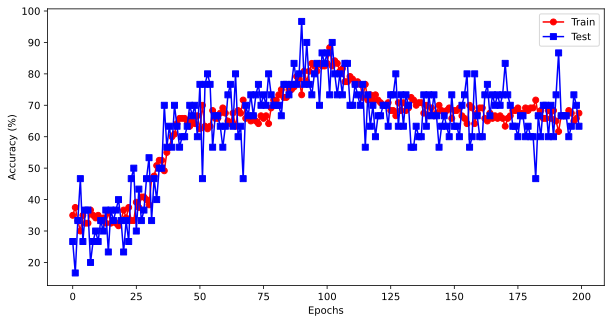

In [27]:
# plot the results
fig = plt.figure(figsize=(10, 5))

plt.plot(trainAcc, "ro-")
plt.plot(testAcc, "bs-")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(["Train", "Test"])
plt.show()

# Train Test Accuracy over training and testing sizes


In [28]:
trainSetSizes = np.linspace(0.2, 0.95, 10)

allTrainAcc = np.zeros((len(trainSetSizes), numepochs))
allTestAcc = np.zeros((len(trainSetSizes), numepochs))

for i in range(len(trainSetSizes)):

    # Create a model
    trainAcc, testAcc = trainTheModel(trainSetSizes[i])

    # Store the results
    allTrainAcc[i, :] = trainAcc
    allTestAcc[i, :] = testAcc

print(trainAcc)

[91.54929518699646, 92.25351810455322, 91.54929518699646, 92.95774698257446, 92.25351810455322, 91.54929518699646, 92.95774698257446, 92.25351810455322, 91.54929518699646, 92.25351810455322, 91.54929518699646, 91.54929518699646, 91.54929518699646, 91.54929518699646, 91.54929518699646, 92.95774698257446, 91.54929518699646, 92.25351810455322, 92.25351810455322, 92.25351810455322, 91.54929518699646, 91.54929518699646, 91.54929518699646, 91.54929518699646, 92.25351810455322, 92.95774698257446, 91.54929518699646, 92.25351810455322, 91.54929518699646, 91.54929518699646, 92.95774698257446, 91.54929518699646, 92.25351810455322, 92.25351810455322, 92.25351810455322, 91.54929518699646, 91.54929518699646, 92.25351810455322, 91.54929518699646, 93.66196990013123, 92.95774698257446, 93.66196990013123, 92.25351810455322, 92.25351810455322, 92.95774698257446, 92.95774698257446, 92.25351810455322, 92.95774698257446, 92.25351810455322, 91.54929518699646, 91.54929518699646, 92.25351810455322, 91.54929518

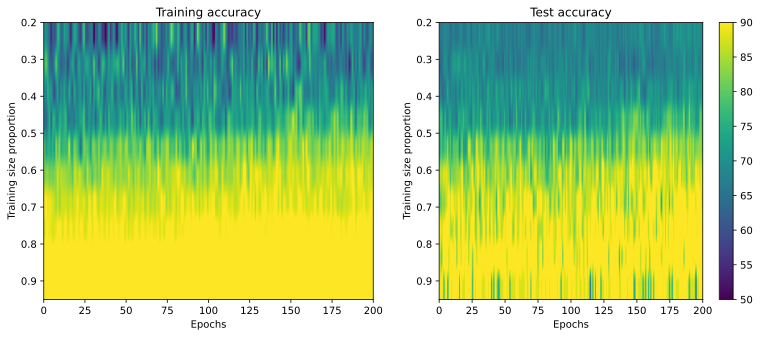

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

ax[0].imshow(
    allTrainAcc,
    aspect="auto",
    vmin=50,
    vmax=90,
    extent=[0, numepochs, trainSetSizes[-1], trainSetSizes[0]],
)
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Training size proportion")
ax[0].set_title("Training accuracy")

p = ax[1].imshow(
    allTestAcc,
    aspect="auto",
    vmin=50,
    vmax=90,
    extent=[0, numepochs, trainSetSizes[-1], trainSetSizes[0]],
)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training size proportion")
ax[1].set_title("Test accuracy")
fig.colorbar(p, ax=ax[1])

plt.show()